In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

First, construct a Gaussian distribtion of temperature and TOA imbalance

In [34]:
nsamp=10000
dT = np.random.normal(loc=0.91,scale=0.11/1.96,size=nsamp)
dQ = np.random.normal(0.61,0.14/1.96,size=nsamp)

Now, take samples of F and $F_{2\times CO_2}$

In [35]:
dF2xCO2_dist =np.random.normal(3.8,0.74/1.96,size=nsamp)
dF = dF2xCO2_dist - np.random.normal(1.46,0.77/1.96,size=nsamp) 

Collate into a single array:

x=$\Delta F$

y=$\Delta Q$

z=$\Delta T$

In [36]:
values = np.zeros((3,nsamp))
values[2]=dT
values[0]=dF
values[1]=dQ

Now calculate a kernel density estimate from these samples

In [37]:
kde = stats.gaussian_kde(values)

Evaluate the kernel density at the samples in order to plot

Text(0.5,0,'$\\Delta$T')

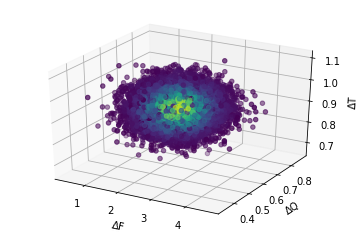

In [38]:
density = kde(values)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(dF, dQ, dT, c=density)
ax.set_xlabel(r'$\Delta$F')
ax.set_ylabel(r'$\Delta$Q')
ax.set_zlabel(r'$\Delta$T')

If $S_{hist}$ is simply related to these quantities through
$$S_{hist} = \frac{F_{2\times CO_2} \Delta T}{\Delta F - \Delta Q}$$
then each value of $S_{hist}$ uniquely defines a plane in $(\Delta F, \Delta Q, \Delta T)$ space.


In [39]:
%%capture
def plot_plane(Shist,ax=plt.gca()):
    Fs = np.linspace(np.min(dF),np.max(dF),nsamp)
    Qs = np.linspace(.3,.9,nsamp)
    xx,yy=np.meshgrid(Fs,Qs)
    zz = Shist/3.8*(xx-yy)
    ax.plot_surface(xx,yy,zz,alpha=.3,label="Shist = "+str(Shist));

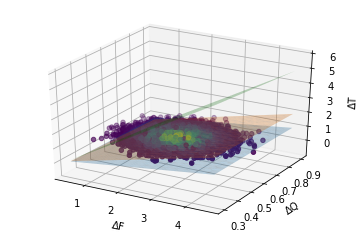

In [40]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(dF, dQ, dT, c=density)
ax.set_xlabel(r'$\Delta$F')
ax.set_ylabel(r'$\Delta$Q')
ax.set_zlabel(r'$\Delta$T')
plot_plane(1,ax)
plot_plane(2,ax)
plot_plane(5,ax)

The likelihood of a particular $S_{hist}$ is the area of the intersection of the plane defined by $S_{hist}$ and the 3D kernel density.  Note that here, we're not \emph{sampling} values of $\Delta F$ or $\Delta Q$, we're just using them to define the plane.

In [ ]:
likelihood = []
Fs = np.linspace(np.min(dF),np.max(dF),nsamp)
Qs = np.linspace(.3,.9,nsamp)
Shist_possibilities = np.arange(.1,10,.1)
for Shist in Shist_possibilities:
    #the plane is given by
    Ts = Shist * (Fs-Qs)/dF2xCO2_dist
    #now evaluate the kernel density on the plane using kde
    Svals=np.vstack((Fs,Qs,Ts))
    likelihood += [np.sum(kde(Svals))/float(nsamp)]

Now plot the likelihood of different values of $S_{hist}$

In [ ]:
plt.plot(Shist_possibilities,likelihood)